# Install necessary libraries

In [ ]:
!pip install torch torchvision torchmetrics thop


In [ ]:
! pip install torchprofile

In [ ]:
!pip install -U fvcore

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import os


from PIL import Image

#from torchmetrics import JaccardIndex
#from thop import profile, clever_format
import time

#from fvcore.nn import FlopCountAnalysis, flop_count_table
#import torchprofile

#from models.deeplabv2.deeplabv2 import get_deeplab_v2


from torchmetrics import JaccardIndex
from thop import profile, clever_format
import time

from fvcore.nn import FlopCountAnalysis, flop_count_table
import torchprofile





**Cityscapes Dataset Download**

In [ ]:

from google.colab import drive
import pathlib
drive.mount('/content/Drive')
get_ipython().system('/content/Drive/MyDrive/Cityscapes/Cityscapes')

**GTA5 Dataset**

In [ ]:
from google.colab import drive
import pathlib
drive.mount('/content/Drive')
get_ipython().system('/content/Drive/MyDrive/GTA5')

**Model Clone**

In [ ]:
# Clone the GitHub repository
!git clone https://github.com/Gabrysse/MLDL2024_project1.git


In [ ]:
# Navigate to the project directory
%cd MLDL2024_project1

In [ ]:

from models.bisenet.build_bisenet import BiSeNet

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Parameters**

In [ ]:
# Define training parameters
epochs = 50
learning_rate = 0.0001
batch_size = 4
train_resolution = (1280,720) #(1024, 512)
test_resolution = (1024, 512)


In [ ]:
class CityscapesDataset(Dataset):
  def __init__(self, root_dir, im_transform ):

    """
    Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied on a sample.
    """
    self.root_dir = root_dir
    self.im_transform = im_transform

    self.images = []
    for subdir, dirs, files in os.walk(root_dir):
      for file in files:
          self.images.append(os.path.join(subdir, file))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_name = self.images[idx]
    image = Image.open(img_name).convert('RGB')
    label_name = img_name.replace('images', 'gtFine').replace('_leftImg8bit','_gtFine_labelTrainIds')  #labelTrainIds


    label = Image.open(label_name).convert('L')




    # Resize label using nearest-neighbor interpolation
    label = TF.resize(label, (512,1024 ), interpolation=transforms.InterpolationMode.NEAREST)
    label = np.array(label)  # Convert to numpy array
    label = torch.from_numpy(label).long()  # Convert to LongTensor


    if self.im_transform:

      image = self.im_transform(image)


    return image, label



In [ ]:
class GTA5Dataset(Dataset):
  def __init__(self, root_dir, im_transform=None):
    """
    Args:
    root_dir (string): Directory with all the images and labels.
    im_transform (callable, optional): Optional transform to be applied on a sample.
    """
    self.root_dir = root_dir
    self.im_transform = im_transform
    self.transform=im_transform
    self.images_dir = os.path.join(root_dir, 'images')
    self.labels_dir = os.path.join(root_dir, 'labels')
    self.images = [os.path.join(self.images_dir, file) for file in os.listdir(self.images_dir) if file.endswith('.png')]
    self.id_to_trainid = {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
                              19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
                              26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18}

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_name = self.images[idx]
    image = Image.open(img_name).convert('RGB')
    label_name = img_name.replace('images', 'labels')
    label = Image.open(label_name)




     # resize

    image = image.resize((1280,720), Image.BICUBIC)
    label = label.resize((1280,720), Image.NEAREST)

    image = np.array(image)
    label = np.array(label)




     # re-assign labels to match the format of Cityscapes
    label_copy = 255 * np.ones(label.shape)
    for k, v in self.id_to_trainid.items():
        label_copy[label == k] = v




    label_copy = torch.from_numpy(label_copy).long()  # Convert to LongTensor

    if self.im_transform:
      image = self.im_transform(image)



    return image, label_copy


**GTA5 Augmented Train Loader**

In [ ]:

###-----   Augmentation Transforms:

# Create the dataset with augmentations
im_transform = transforms.Compose([
transforms.ToTensor(),
#transforms.Resize(train_resolution),
#transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),  # Apply Gaussian Blur with 50% probability
transforms.RandomApply([transforms.ColorJitter(brightness=0.5)], p=0.5),  # Apply brightness adjustment with 50% probability

                                    ])



gta5_dataset = GTA5Dataset(root_dir='/content/Drive/MyDrive/GTA5', im_transform=im_transform)




In [ ]:
train_loader = DataLoader(gta5_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

**Citescapes Train Loader**

In [ ]:

# Load the BiSeNet model
model = BiSeNet(num_classes=19,context_path='resnet18')  #BiSeNet


model = model.to(device)



# Define the CrossEntropyLoss with ignore_index set to 255
criterion = nn.CrossEntropyLoss(ignore_index=255)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Define the metric for mIoU
miou_metric = JaccardIndex(num_classes=19, task='multiclass' , ignore_index=255).to(device)


In [ ]:
# Function to compute latency
def measure_latency(model, input_tensor, repetitions=100):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(repetitions):
            _ = model(input_tensor)
        end = time.time()
    latency = (end - start) / repetitions
    return latency



# Measure FLOPs and number of parameters


dummy_input = torch.randn(1, 3, 1024, 512).to(device)

height = 1024
width = 512
image =torch.zeros((1,3, height, width)).to(device)   # torch.randn(1,3, 1024, 512).to(device)#

model.eval()
flops = FlopCountAnalysis(model, image)
print(flop_count_table(flops))



In [ ]:
# Measure FLOPs and parameters using torchprofile
dummy_input = torch.randn(1, 3, 1024,512).to(device)
model.eval()
flops = torchprofile.profile_macs(model, args=(dummy_input,))

params = sum(p.numel() for p in model.parameters())

print(f' flops={flops}\n params={params} ')


**IoU Calculation Function for Classes**

In [ ]:
def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    #k = (a >= 0) & (a < n)
    k = (b >= 0) & (b < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

**Training**

In [ ]:

from pathlib import Path
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/Drive')
get_ipython().system('/content/Drive/MyDrive/Checkpoints/3b/3b_blur_bright_0.0001_4')

In [ ]:
# Function to save the model
def save_checkpoint(epoch, model, optimizer, save_dir='/content/Drive/MyDrive/Checkpoints/3b/3b_blur_bright_0.0001_4'):
    # Ensure the save directory exists
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Define the model filename with the epoch number
    checkpoint_filename = f'checkpoint_epoch_{epoch}.pth'
    checkpoint_path = os.path.join(save_dir, checkpoint_filename)

    # Save the model and optimizer state dictionaries
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f'Model and optimizer saved to {checkpoint_path}')

# Function to load the model
def load_checkpoint(epoch, model, optimizer, save_dir='/content/Drive/MyDrive/Checkpoints/3b/3b_blur_bright_0.0001_4'):
    checkpoint_filename = f'checkpoint_epoch_{epoch}.pth'
    checkpoint_path = os.path.join(save_dir, checkpoint_filename)

    # Check if the file exists
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"The specified file was not found: {checkpoint_path}")

    # Load the model and optimizer state dictionaries
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

    print(f'Model and optimizer loaded from {checkpoint_path}, resuming at epoch {start_epoch}')
    return model, optimizer, start_epoch



In [ ]:
# Training loop
# Resume training from the last checkpoint if available
resume_training =True   # Set this to True if you want to resume training

epochs = 50  # Set this to the total number of epochs you want to train

if resume_training:
    epoch_to_resume =19 #9,19,29,39,49  # Set this to the epoch from which you want to resume
    try:
        model, optimizer, start_epoch = load_checkpoint(epoch_to_resume, model, optimizer)

    except FileNotFoundError as e:
        print(e)
        start_epoch = 0
else:
    start_epoch = 0

for epoch in range(start_epoch,epochs):
    model.train()
    running_loss = 0.0
    miou_metric.reset()
    counter=1
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        #labels = labels.squeeze(1)

        loss = criterion(outputs[0], labels.long())
        #print(loss)
        loss.backward()
        optimizer.step()
        #print(counter)
        counter+=1

        running_loss += loss.item()

        miou_metric.update(outputs[0].argmax(dim=1), labels)

     # Save the model every 10 epochs
    if (epoch+1) % 10 == 0:
        save_checkpoint(epoch, model, optimizer)

    miou = miou_metric.compute().item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}, Train mIoU: {miou}')

# Measure latency after training
latency = measure_latency(model, dummy_input)
print(f"FLOPs: {flops}, Params: {params}, Latency: {latency:.6f} seconds")

print("Training completed!")


**Test Loader**

In [ ]:
# Define a transform if you need to preprocess the images
transformed_dataset = CityscapesDataset(root_dir='/content/Drive/MyDrive/Cityscapes/Cityscapes/images/val',
im_transform=transforms.Compose([

transforms.ToTensor(),
transforms.Resize((512,1024)),

]), )


test_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=8)




**Inference and mIoU calculation on test set**

In [ ]:



model.eval()
miou_metric.reset()

all_classes_iou=np.zeros(19)
test_counter=0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)




        #calcualting IoU for each class and for each (image,label) pair separately
        current_batch_size = labels.size(0)
        for i in range(current_batch_size):

            mask=labels[i,:,:].cpu().numpy().flatten() != 255
            #hist=fast_hist(outputs[i,:,:,:].argmax(dim=0).cpu().numpy().flatten()[mask] , labels[i,:,:].cpu().numpy().flatten()[mask], 19)

            hist=fast_hist(outputs[i,:,:,:].argmax(dim=0).cpu().numpy().flatten() , labels[i,:,:].cpu().numpy().flatten(), 19)

            all_classes_iou=all_classes_iou+per_class_iou(hist)
            test_counter = test_counter +1





In [ ]:
test_counter

In [ ]:
all_classes_mIOU=(all_classes_iou/test_counter).round(3)  #calculating mean intersection over union for each class

In [ ]:
all_classes_mIOU

In [ ]:
mIoU=all_classes_mIOU.mean()  #

In [ ]:
mIoU

**GTA5 Labels**

In [ ]:
from abc import ABCMeta
from dataclasses import dataclass
from typing import Tuple


class BaseGTALabels(metaclass=ABCMeta):
    pass


@dataclass
class GTA5Label:
    ID: int
    color: Tuple[int, int, int]


class GTA5Labels_TaskCV2017(BaseGTALabels):
    road = GTA5Label(ID=0, color=(128, 64, 128))
    sidewalk = GTA5Label(ID=1, color=(244, 35, 232))
    building = GTA5Label(ID=2, color=(70, 70, 70))
    wall = GTA5Label(ID=3, color=(102, 102, 156))
    fence = GTA5Label(ID=4, color=(190, 153, 153))
    pole = GTA5Label(ID=5, color=(153, 153, 153))
    light = GTA5Label(ID=6, color=(250, 170, 30))
    sign = GTA5Label(ID=7, color=(220, 220, 0))
    vegetation = GTA5Label(ID=8, color=(107, 142, 35))
    terrain = GTA5Label(ID=9, color=(152, 251, 152))
    sky = GTA5Label(ID=10, color=(70, 130, 180))
    person = GTA5Label(ID=11, color=(220, 20, 60))
    rider = GTA5Label(ID=12, color=(255, 0, 0))
    car = GTA5Label(ID=13, color=(0, 0, 142))
    truck = GTA5Label(ID=14, color=(0, 0, 70))
    bus = GTA5Label(ID=15, color=(0, 60, 100))
    train = GTA5Label(ID=16, color=(0, 80, 100))
    motocycle = GTA5Label(ID=17, color=(0, 0, 230))
    bicycle = GTA5Label(ID=18, color=(119, 11, 32))

    list_ = [
        road,
        sidewalk,
        building,
        wall,
        fence,
        pole,
        light,
        sign,
        vegetation,
        terrain,
        sky,
        person,
        rider,
        car,
        truck,
        bus,
        train,
        motocycle,
        bicycle,
    ]

    @property
    def support_id_list(self):
        ret = [label.ID for label in self.list_]
        return ret

In [ ]:
class_labels = []
for label_name, label in GTA5Labels_TaskCV2017.__dict__.items():
  if isinstance(label, GTA5Label):
    class_labels.append(label_name)

In [ ]:
class_labels

In [ ]:
import pandas as pd

In [ ]:
# Create a DataFrame
all_classes_mIOU_DF = pd.DataFrame({
'class_Label': class_labels,
'class_IoU': all_classes_mIOU
})

all_classes_mIOU_DF


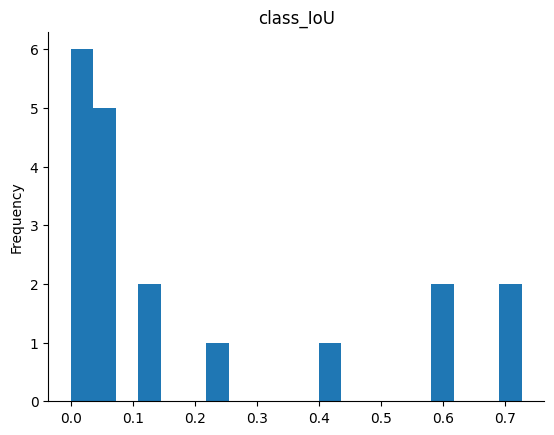

In [ ]:
# @title class_IoU

from matplotlib import pyplot as plt
all_classes_mIOU_DF['class_IoU'].plot(kind='hist', bins=20, title='class_IoU')
plt.gca().spines[['top', 'right',]].set_visible(False)